In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

plt.style.use('ggplot')
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 50)

# datos incidentes de transito

dataset original sobre accidentes de transito en la ciudad de medellin, Colombia

#### carga de datos

se cargan los datos desde la carpeta correspondiente, cada carpeta vendria a ser en nuestra arquitecura de nube un origen de los datos en nuestro data lake

In [2]:
def load_data_incidentes():
    PATH_TO_DATA = "data_incidentes"

    datos = []
    for file in os.listdir(PATH_TO_DATA):
        datos.append( pd.read_csv(os.path.join(PATH_TO_DATA, file), encoding="latin-1") )

    datos = pd.concat(datos, axis=0, ignore_index=True)

    return datos

#### seleccion de columnas

**Los datos vienen inicialmente con las siguientes columnas**

<span style="color: red;">

- **BARRIO** : barrio de ocurrencia del incidente vial

- **COMUNA**: Comuna de ocurrencia del incidente vial

- **GRAVEDAD**: Clasificación del IPAT - Informe Policial de Accidentes de Tránsito, sobre la gravedad del accidente, corresponde al resultado más grave presentado en el accidente. Daños materiales "Sólo daños", accidente con heridos "Herido", accidente con muertos "Muerto". No indica cantidad

- **CLASE**: Clasificación del IPAT sobre la clase de accidente de transito: choque, atropello, volcamiento, caida de ocupante, incendio,  u otro (que no corresponde a las anteriores 5 clasificaciones, p. ej: sumersión)

- **DISENO**: Sitio de la vía donde ocurrió el accidente: Cicloruta, Glorieta, Interseccion, Lote o Predio, Paso a Nivel, Paso Elevado, Paso Inferior, Pontón, Puente, Tramo de via, Tunel, Via peatonal

- **LATITUD**: Coordenada norte-sur para expresar la ubicación geográfica en el sistema de coordenadas WGS 84

- **LONGITUD**: Coordenada este-oeste para expresar la ubicación geográfica en el sistema de coordenadas WGS 84

- **FECHA**: Fecha del incidente, proviene del IPAT - Informe Policial de incidentes de Tránsito 

- **HORA**: Hora del incidente, proviene del IPAT - Informe Policial de incidentes de Tránsito 

- **DIA_NOMBRE**: Día en que tiene ocurrencia del incidente vial

- **MES_NOMBRE**: Nombre del mes de ocurrencia del incidente vial

- **PERIODO**: Año de ocurrencia del incidente

</span>

- **DIA**: Dia del mes de ocurrencia del incidente vial

- **MES**: Número de mes de ocurrencia del incidente vial

- **DIRECCION**: Dirección donde ocurrió el incidente

- **DIRECCION_ENC**: Dirección encasillada que entrega el geocodificador

- **CBML**: Codigo catastral que corresponde al codigo comuna, barrio, manzana, lote catastral  de un predio.

- **OBJECTID**: no esta en el diccionario de datos, sin embargo se puede suponer que es un identificador del registro

- **RADICADO**: Consecutivo que asigna UNE, según el orden de llegada de los expedientes para su diligenciamiento

- **Shape**: no esta en el diccionario de datos, y no se sabe bien que representa

- **TIPO_GEOCOD**: Fuente de información con la cual se realizó la geocodificación

- **X_MAGNAMED**: Coordenada X en metros, en sistema de coordenadas MAGNA Medellin Local (MAGNA_Medellin_Antioquia_2010 WKID: 6257 Authority: EPSG)

- **Y_MAGNAMED**: Coordenada Y en metros, en sistema de coordenadas MAGNA Medellin Local (MAGNA_Medellin_Antioquia_2010 WKID: 6257 Authority: EPSG)

se seleccionan las columnas que son importantes para el analisis

In [3]:
def select_columns_incidentes(datos):
    droped_cols = [
        "OBJECTID", # no es util para el analisis
        "Shape",    # no se sabe que es
    ]

    return datos.drop(columns=droped_cols)

#### limpieza de los datos

In [4]:
datos = load_data_incidentes()
datos = select_columns_incidentes(datos)

datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315087 entries, 0 to 315086
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   RADICADO       315082 non-null  object 
 1   FECHA          315087 non-null  object 
 2   HORA           315087 non-null  object 
 3   DIA            315087 non-null  int64  
 4   PERIODO        315087 non-null  int64  
 5   CLASE          315081 non-null  object 
 6   DIRECCION      315087 non-null  object 
 7   DIRECCION_ENC  313785 non-null  object 
 8   CBML           292794 non-null  object 
 9   TIPO_GEOCOD    315087 non-null  object 
 10  GRAVEDAD       315087 non-null  object 
 11  BARRIO         291948 non-null  object 
 12  COMUNA         293830 non-null  object 
 13  DISENO         313803 non-null  object 
 14  DIA_NOMBRE     315087 non-null  object 
 15  MES            315087 non-null  int64  
 16  MES_NOMBRE     86394 non-null   object 
 17  X_MAGNAMED     315087 non-nul

##### se hicieron los siguientes hallazgos:

 - **FECHA**: no tiene el tipo de dato correcto, se convierte a tipo fecha

 - **HORA**: no tiene el tipo de dato correcto, se convierte a tipo hora

 - **CLASE**: contiene algunos valores nulos, se reemplazan estos valores con `No registra`

 - **DIRECCION_ENC**: contiene algunos valores nulos, se reemplazan estos valores con `No registra`

 - **CBML**: contiene algunos valores nulos, se reemplazan estos valores con `No registra`

 - **BARRIO**: contiene algunos valores nulos, se reemplazan estos valores con `No registra`

 - **COMUNA**: contiene algunos valores nulos, se reemplazan estos valores con `No registra`

 - **DISENO**: contiene algunos valores nulos, se reemplazan estos valores con `No registra`

 - **MES_NOMBRE**: contiene algunos valores nulos, se reemplazan estos valores segun su valor en la columna `MES`

 - **General**: se hace una limpieza general de los datos, donde se realiza: eliminacion de datos duplicados, eliminacion de filas nulas, eliminacion de datos sin radicado, se capitalizan las variables alfanumericas, eliminar espacios en blanco, entre otros

In [5]:
def clean_data_incidentes(datos):
    # eliminar datos duplicados
    datos.drop_duplicates(inplace=True)

    #eliminar filas nulas
    datos.dropna(how="all", inplace=True)

    # eliminar datos sin radicado
    datos.dropna(subset=["RADICADO"], inplace=True)

    # capitalizar variables de tipo strings
    cols_str = datos.select_dtypes(include="object").columns
    cols_str = cols_str.drop("RADICADO")
    for col in cols_str:
        datos[col] = datos[col].str.capitalize()

    # algunas comunas tienen valores no utiles, se cambian a "no registra"
    mask = datos["COMUNA"].str.len() <= 2
    datos.loc[mask, "COMUNA"] = "No registra"

    # reemplazar "Sin inf" por "no registra"
    for col in cols_str:
        datos[col] = datos[col].str.replace("Sin inf", "no registra")

    # eliminar espacios en blanco al inicio y al final de las cadenas
    for col in cols_str:
        datos[col] = datos[col].str.strip()

    # dejar todos los strings sin asentos
    asentos = (("á", "a"), ("é", "e"), ("í", "i"), ("ó", "o"), ("ú", "u"))
    for asen, no_asent in asentos:
        for col in cols_str:
            datos[col] = datos[col].str.replace(asen, no_asent)

    # convertir fechas a tipo de dato datetime
    datos["FECHA"] = pd.to_datetime(datos["FECHA"], format="%Y-%m-%d %H:%M:%S")

    # convertir hora a tipo de dato time
    datos["HORA"] = pd.to_datetime(datos["HORA"], format="mixed").dt.time

    # reemplazar valores nulos
    cols_na = ["CLASE", "DIRECCION_ENC", "CBML", "BARRIO", "COMUNA", "DISENO"]
    for col in cols_na:
        datos[col].fillna("No registra", inplace=True)


    meses = {1: "ENERO", 2: "FEBRERO", 3: "MARZO", 4: "ABRIL", 5: "MAYO", 6: "JUNIO", 7: "JULIO", 8: "AGOSTO", 9: "SEPTIEMBRE", 10: "OCTUBRE", 11: "NOVIEMBRE", 12: "DICIEMBRE"}
    datos["MES_NOMBRE"] = datos["MES"].apply(lambda x: meses[x])
    
    return datos

#### datos limpios

In [6]:
def get_data_incidentes():
    datos = load_data_incidentes()
    datos = select_columns_incidentes(datos)
    datos = clean_data_incidentes(datos)

    return datos

In [7]:
datos = get_data_incidentes()

datos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 315075 entries, 0 to 315086
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   RADICADO       315075 non-null  object        
 1   FECHA          315075 non-null  datetime64[ns]
 2   HORA           315075 non-null  object        
 3   DIA            315075 non-null  int64         
 4   PERIODO        315075 non-null  int64         
 5   CLASE          315075 non-null  object        
 6   DIRECCION      315075 non-null  object        
 7   DIRECCION_ENC  315075 non-null  object        
 8   CBML           315075 non-null  object        
 9   TIPO_GEOCOD    315075 non-null  object        
 10  GRAVEDAD       315075 non-null  object        
 11  BARRIO         315075 non-null  object        
 12  COMUNA         315075 non-null  object        
 13  DISENO         315075 non-null  object        
 14  DIA_NOMBRE     315075 non-null  object        
 15  MES  

# infomacion adicional incidentes

dataset encontrado con informacion adicional de los incidentes de transito en la ciudad de medellin, Colombia

#### carga de datos

In [8]:
def load_data_adicional():
    datos = pd.read_csv("data_adicional\Mede_Victimas_inci.csv", encoding="utf-8")

    return datos

#### seleccion de columnas

se eliminaron las columnas que ya estaban en el dataset de incidentes de transito

**las columnas con las que quedamos son**:

- **Sexo**: Sexo de la víctima en incidente vial

- **Condicion**: "Definición de actor vial de la víctima en el incidente

- **Grupo_edad**: Agrupación de edades de víctimas por decenios

- **Radicado**: Consecutivo que asigna UNE, según el orden de llegada de los expedientes para su diligenciamiento (usado para combinar los datos)

In [9]:
def select_columns_adicional(datos):
    # se eliminan columnas que ya estan en el otro dataset
    droped_cols = [
        "Fecha_incidente",
        "Hora_incidente",
        "Direccion_incidente",
        "Mes",
        "Dia",
        "Num_dia",
        "Hora",
        "Edad",
        "Año",
        "Latitud",
        "Longitud",
        "Comuna",
        "Barrio",
        "Gravedad_victima",
        "Clase_incidente"
    ]

    return datos.drop(columns=droped_cols)

#### limpieza de datos

In [10]:
datos = load_data_adicional()
datos = select_columns_adicional(datos)

datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048317 entries, 0 to 1048316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Sexo        235843 non-null  object
 1   Condicion   235843 non-null  object
 2   Grupo_edad  235843 non-null  object
 3   Radicado    235838 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


**Se hicieron los siguientes hallazgos**: 

- hay muchas filas completas de valores nulos

- Se eliminan filas duplicadas, se eliminan filas nulas, se eliminan filas sin radicado, se capitalizan las variables alfanumericas, eliminar espacios en blanco, entre otros

In [11]:
def clean_data_adicional(datos):
    # eliminar datos duplicados
    datos.drop_duplicates(inplace=True)

    # eliminar filas nulas
    datos.dropna(how="all", inplace=True)

    # eliminar datos sin radicado
    datos.dropna(subset=["Radicado"], inplace=True)

    # capitalizar variables de tipo strings
    cols_str = datos.select_dtypes(include="object").columns
    cols_str = cols_str.drop("Radicado")
    for col in cols_str:
        datos[col] = datos[col].str.capitalize()

    # reemplazar "sin inf" por "no registra"
    for col in cols_str:
        datos[col] = datos[col].str.replace("Sin inf", "no registra")

    # eliminar espacios en blanco al inicio y al final de las cadenas
    for col in cols_str:
        datos[col] = datos[col].str.strip()

    return datos

#### datos limpios

In [12]:
def get_data_adicional():
    datos = load_data_adicional()
    datos = select_columns_adicional(datos)
    datos = clean_data_adicional(datos)

    return datos

In [13]:
datos = get_data_adicional()

datos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233220 entries, 0 to 235842
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Sexo        233220 non-null  object
 1   Condicion   233220 non-null  object
 2   Grupo_edad  233220 non-null  object
 3   Radicado    233220 non-null  object
dtypes: object(4)
memory usage: 8.9+ MB


# Cruce de los datos

Al realizar el merge de los datos por el radicado, se encontro que muchos datos no estan en ambos dataframes, sin embargo quedaron 143.971 datos, lo cual segun se discutio en el equipo, consideramos suficiente para realizar el analisis

In [14]:
def get_data():
    datos_incidentes = get_data_incidentes()
    datos_adicional = get_data_adicional()

    datos = pd.merge(datos_incidentes, datos_adicional, left_on="RADICADO", right_on="Radicado", how="inner")

    return datos.drop(columns=["Radicado"])

In [15]:
datos = get_data()

datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143971 entries, 0 to 143970
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   RADICADO       143971 non-null  object        
 1   FECHA          143971 non-null  datetime64[ns]
 2   HORA           143971 non-null  object        
 3   DIA            143971 non-null  int64         
 4   PERIODO        143971 non-null  int64         
 5   CLASE          143971 non-null  object        
 6   DIRECCION      143971 non-null  object        
 7   DIRECCION_ENC  143971 non-null  object        
 8   CBML           143971 non-null  object        
 9   TIPO_GEOCOD    143971 non-null  object        
 10  GRAVEDAD       143971 non-null  object        
 11  BARRIO         143971 non-null  object        
 12  COMUNA         143971 non-null  object        
 13  DISENO         143971 non-null  object        
 14  DIA_NOMBRE     143971 non-null  object        
 15  

In [16]:
datos.to_csv("datos.csv", index=False)

# exploracion inicial de los datos

In [17]:
data_incidentes_raw = load_data_incidentes()
data_incidentes_raw = select_columns_incidentes(data_incidentes_raw)
data_incidentes_clean = clean_data_incidentes(data_incidentes_raw.copy())

data_adicional_raw = load_data_adicional()
data_adicional_raw = select_columns_adicional(data_adicional_raw)
data_adicional_clean = clean_data_adicional(data_adicional_raw.copy())

data_merged = get_data()

### datos incidentes de transito

In [18]:
print("Numero de datos crudos: ", data_incidentes_raw.shape[0],
      "\nNumero de datos limpios: ", data_incidentes_clean.shape[0])

Numero de datos crudos:  315087 
Numero de datos limpios:  315075


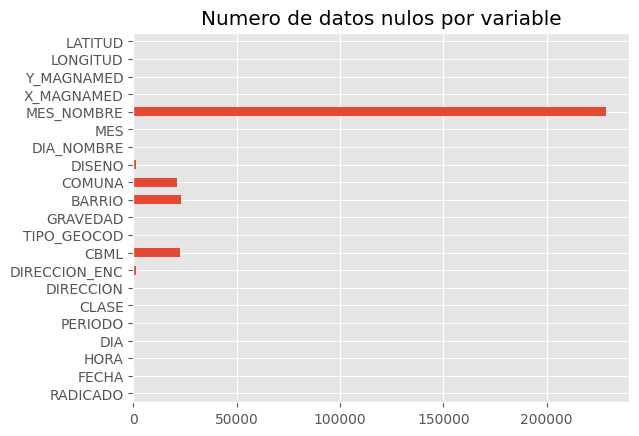

In [19]:
data_incidentes_raw.isna().sum().plot.barh()

plt.title("Numero de datos nulos por variable")
plt.show()

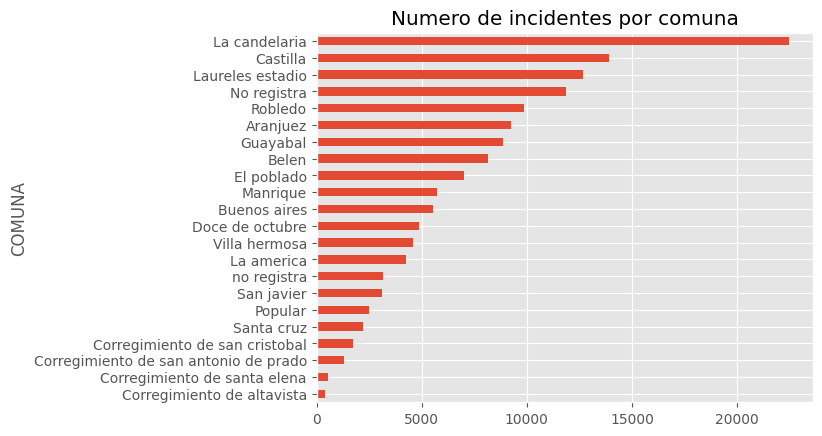

In [20]:
data_comuna = data_merged["COMUNA"].copy()

data_comuna = data_comuna.value_counts(sort=True, ascending=True)

data_comuna = data_comuna[data_comuna > 40]

data_comuna.plot.barh()

plt.title("Numero de incidentes por comuna")
plt.show()

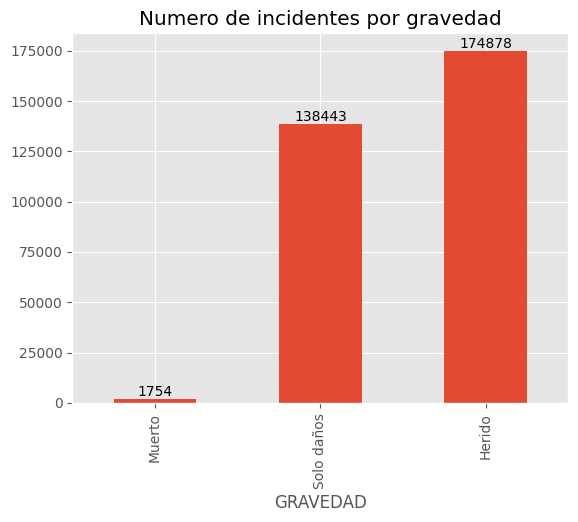

In [32]:
data_gravedad = data_incidentes_clean["GRAVEDAD"].copy()

data_gravedad = data_gravedad.value_counts(sort=True, ascending=True)

data_gravedad.plot.bar()

for cont in plt.gca().containers:
    plt.bar_label(container=cont)

plt.title("Numero de incidentes por gravedad")
plt.show()

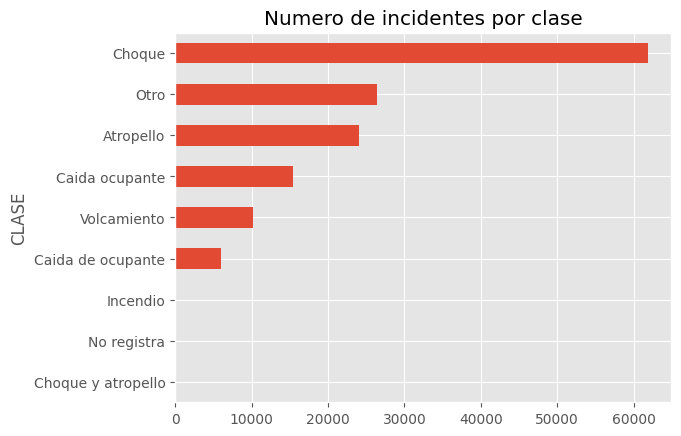

In [22]:
data_clase = data_merged["CLASE"].copy()

data_clase = data_clase.value_counts(sort=True, ascending=True)

data_clase.plot.barh()

plt.title("Numero de incidentes por clase")

plt.show()

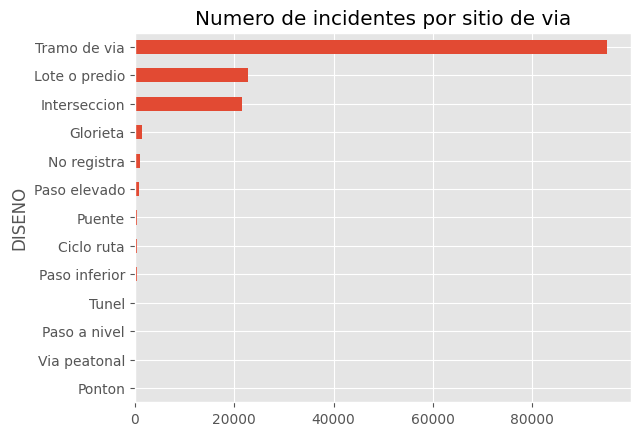

In [23]:
data_diseno = data_merged["DISENO"].copy()

data_diseno = data_diseno.value_counts(sort=True, ascending=True)

data_diseno.plot.barh()

plt.title("Numero de incidentes por sitio de via")
plt.show()

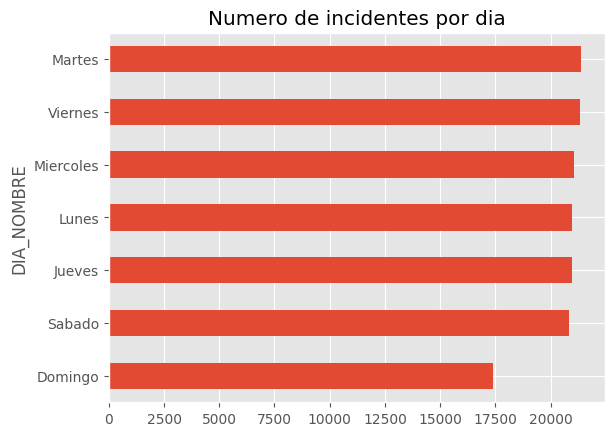

In [24]:
data_dia = data_merged["DIA_NOMBRE"].copy()

data_dia = data_dia.value_counts(sort=True, ascending=True)

data_dia.plot.barh()

plt.title("Numero de incidentes por dia")
plt.show()

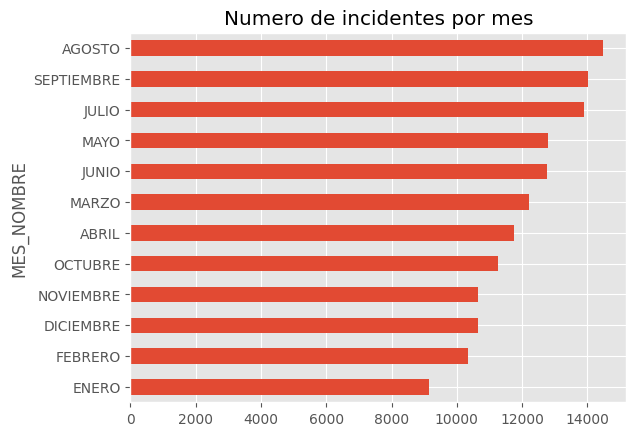

In [25]:
data_mes = data_merged["MES_NOMBRE"].copy()

data_mes = data_mes.value_counts(sort=True, ascending=True)

data_mes.plot.barh()

plt.title("Numero de incidentes por mes")
plt.show()

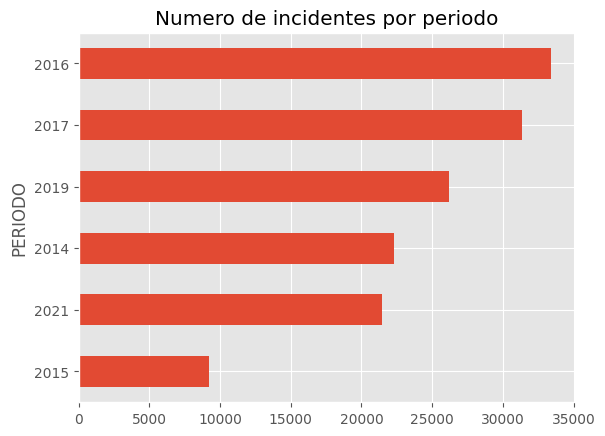

In [26]:
data_periodo = data_merged["PERIODO"].copy()

data_periodo = data_periodo.value_counts(sort=True, ascending=True)

data_periodo.plot.barh()

plt.title("Numero de incidentes por periodo")
plt.show()

### datos adicionales

In [27]:
print("Numero de datos crudos: ", data_adicional_raw.shape[0],
      "\nNumero de datos limpios: ", data_adicional_clean.shape[0])

Numero de datos crudos:  1048317 
Numero de datos limpios:  233220


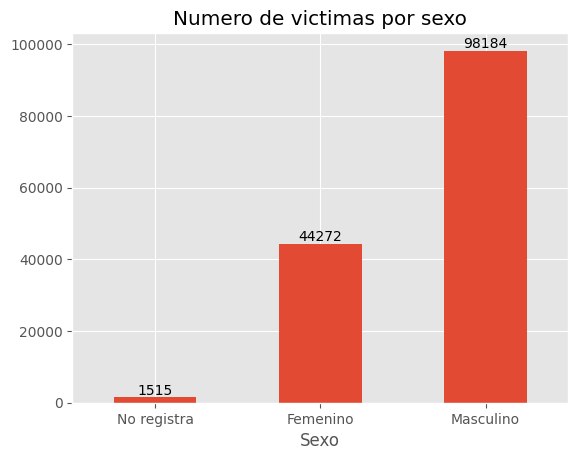

In [28]:
data_sexo = data_merged["Sexo"].copy()

data_sexo = data_sexo.value_counts(sort=True, ascending=True)

data_sexo.plot.bar()

for cont in plt.gca().containers:
    plt.bar_label(container=cont)

plt.title("Numero de victimas por sexo")
plt.xticks(rotation=0)
plt.gca().set_xticklabels(["No registra", "Femenino", "Masculino"])
plt.show()

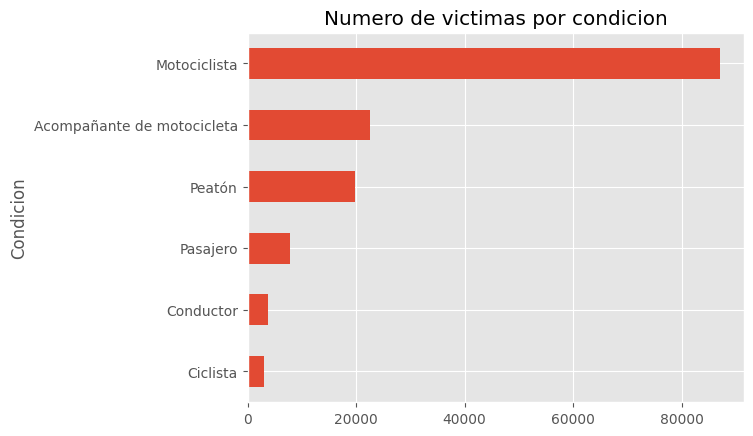

In [29]:
data_condicion = data_merged["Condicion"].copy()

data_condicion = data_condicion.value_counts(sort=True, ascending=True)

data_condicion.plot.barh()

plt.title("Numero de victimas por condicion")
plt.show()

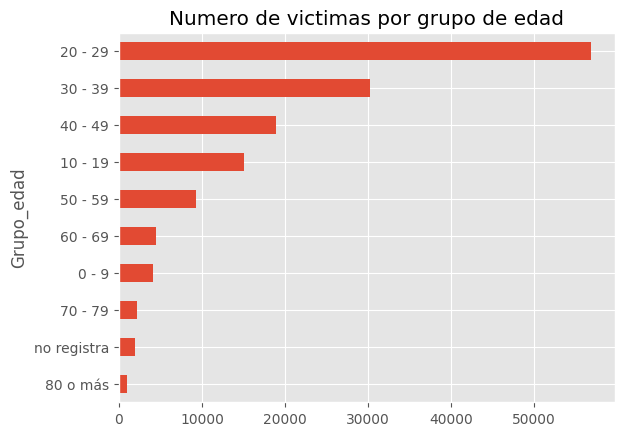

In [30]:
data_grupo_edad = data_merged["Grupo_edad"].copy()

data_grupo_edad = data_grupo_edad.value_counts(sort=True, ascending=True)

data_grupo_edad.plot.barh()

plt.title("Numero de victimas por grupo de edad")
plt.show()

### datos cruzados

In [31]:
print("Numero de datos despues de cruzarlos", data_merged.shape[0])

Numero de datos despues de cruzarlos 143971
